In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from tqdm import tqdm
tqdm.pandas()

from utils import heston_pricer

In [3]:
import tensorflow as tf
import keras as K
from keras.callbacks import EarlyStopping

In [4]:
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s', level=logging.INFO)

In [5]:
class FeatureScaler(object):
    def __init__(self, train):
        self.mean = train.mean(axis=0)
        self.std = train.std(axis=0)
    
    def transform(self, df):
        return (df - self.mean) / self.std
    
    def inverse_transform(self, df):
        return df * self.std + self.mean
    
    def get_params(self):
        return self.mean, self.std

In [6]:
def build_nn(input_length, hidden_layer_sizes = [20, 10, 5]):
    model = K.models.Sequential()
    kernel_init = K.initializers.RandomNormal(stddev=np.sqrt(2.0/input_length))
    model.add(K.layers.Dense(units=hidden_layer_sizes[0], activation='relu', kernel_initializer=kernel_init, 
                             input_shape=[input_length]))
    for layer_idx in range(1, len(hidden_layer_sizes)):
        kernel_init = K.initializers.RandomNormal(stddev=np.sqrt(2.0/hidden_layer_sizes[layer_idx-1]))
        model.add(K.layers.Dense(units=hidden_layer_sizes[layer_idx], kernel_initializer=kernel_init, activation='relu'))
    kernel_init = K.initializers.RandomNormal(stddev=np.sqrt(2.0/hidden_layer_sizes[-1]))
    model.add(K.layers.Dense(units=1, kernel_initializer=kernel_init, activation='linear'))
    return model

In [7]:
def train_nn(X_train, Y_train, X_val, Y_val, batch_size=128, n_epochs=50, hidden_layer_sizes=[20, 10, 5], verbose=1):
    n_features = X_train.shape[1]
    model = build_nn(n_features, hidden_layer_sizes)
    
    if verbose != 0:
        print("Neural Network Architechture:")
        print(model.summary())
        print('\n')
    
    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=verbose, mode='auto', restore_best_weights=True)
    train_log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, verbose=verbose, 
                          validation_data=(X_val, Y_val), callbacks=[early_stopping])
    
    return model, train_log.history

In [8]:
def plot_learning_history(history):
    plt.figure()
    plt.plot(history['loss'], color='b', marker='o', label='train loss')
    plt.plot(history['val_loss'], color='r', marker='o', label='val loss')
    plt.xlabel("epochs")
    plt.ylabel('loss')
    plt.legend(loc=1)
    plt.show()

In [10]:
train = pd.read_csv("./data/rBergomi/ftse_0118_train.csv").dropna()
val = pd.read_csv("./data/rBergomi/ftse_0118_val.csv").dropna()
test = pd.read_csv("./data/rBergomi/ftse_0118_test.csv").dropna()

In [11]:
train.shape, val.shape, test.shape

((263631, 9), (17560, 9), (11720, 9))

In [12]:
train = train.drop(columns=['label','index'])
val = val.drop(columns=['label','index'])
test = test.drop(columns=['label','index'])

In [13]:
train = train[['H', 'Moneyness', 'Time to Maturity (years)', 'eta', 'rho', 'v0', 'iv']]
val = val[['H', 'Moneyness', 'Time to Maturity (years)', 'eta', 'rho', 'v0', 'iv']]
test = test[['H', 'Moneyness', 'Time to Maturity (years)', 'eta', 'rho', 'v0', 'iv']]

In [14]:
X_train_origin, Y_train = train.iloc[:, :-1], train.iloc[:, [-1]]
X_val_origin, Y_val = val.iloc[:, :-1], val.iloc[:, [-1]]
X_test_origin, Y_test = test.iloc[:, :-1], test.iloc[:, [-1]]

In [15]:
X_train_origin.head()

,H,Moneyness,Time to Maturity (years),eta,rho,v0
0,0.119790,0.940696,0.041295,2.225799,-0.997984,0.165429
1,0.036204,0.947760,0.398704,1.647835,-0.836806,0.164353
2,0.154546,0.995318,0.266474,3.174934,-0.873824,0.114578
3,0.087680,0.965748,0.250895,2.512963,-0.878655,0.053254
4,0.111961,1.007250,0.310239,2.793560,-0.754466,0.108721


In [16]:
SCALER = FeatureScaler(X_train_origin)
X_train = SCALER.transform(X_train_origin)
X_val = SCALER.transform(X_val_origin)
X_test = SCALER.transform(X_test_origin)

In [17]:
X_train.shape, Y_train.shape

((263631, 6), (263631, 1))

In [18]:
X_train.head()

,H,Moneyness,Time to Maturity (years),eta,rho,v0
0,0.782763,-0.509980,-1.316150,-0.351555,-1.580655,1.428017
1,-1.122477,-0.438684,-0.031326,-1.585436,0.151045,1.405011
2,1.574964,0.041318,-0.506668,1.674728,-0.246680,0.340468
3,0.050864,-0.257134,-0.562674,0.261504,-0.298577,-0.971038
4,0.604307,0.161745,-0.349342,0.860542,1.035707,0.215226


In [19]:
# parameters
hidden_layer_sizes = [20, 10, 5]
batch_size = 128
n_epochs = 50

In [20]:
model, history = train_nn(X_train, Y_train, X_val, Y_val, batch_size, n_epochs, hidden_layer_sizes, verbose=1)

Neural Network Architechture:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                140       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 411
Trainable params: 411
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/50
2060/2060 [==============================] - 5s 2ms/step - loss: 0.0353 - val_loss: 8.4971e-04
Epoch 2/50
2060/2060 [==============================] - 4s 2ms/step - loss: 7.4805e-04 - val_loss: 5.2154e-04
Epo

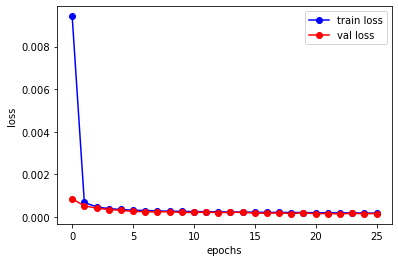

In [21]:
plot_learning_history(history)

In [22]:
model.evaluate(X_test, Y_test)

367/367 [==============================] - 0s 926us/step - loss: 1.7515e-04


0.00017515024228487164

In [23]:
model.save("rBergomi.h5")

In [24]:
pred_test = model.predict(X_test).flatten()
true_test = Y_test.values.flatten()
relative_error = 100 * np.abs(pred_test - true_test) / true_test

In [25]:
sorted_re = sorted(relative_error)
q_90 = sorted_re[int(0.90*len(relative_error))]
q_95 = sorted_re[int(0.95*len(relative_error))]
q_99 = sorted_re[int(0.99*len(relative_error))]

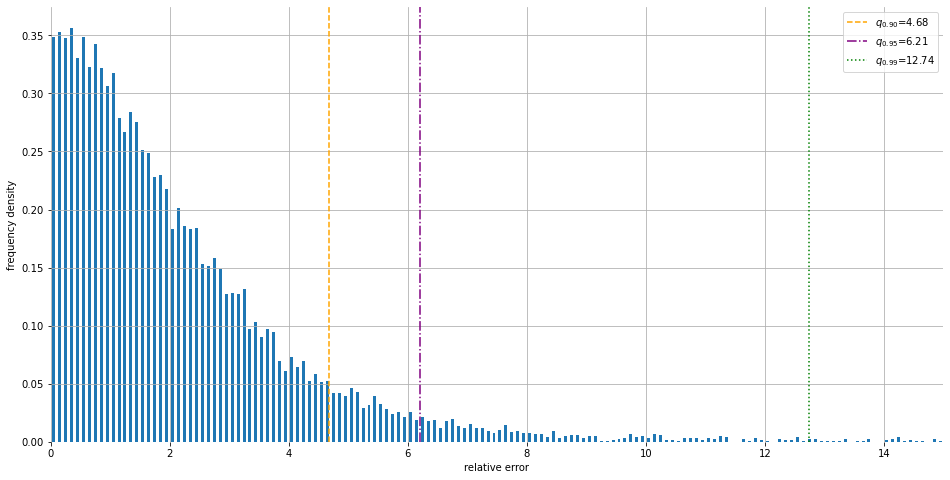

In [26]:
plt.figure(figsize=(16, 8))
plt.hist(relative_error, bins=np.linspace(0, 15, 151), density=True, rwidth=0.5)
plt.xlim((0, 15))
sns.despine(left=True, bottom=True, right=True)
plt.grid(True)
plt.axvline(x=q_90, ls='--', color='orange', label=r"$q_{0.90}$"+"={:.2f}".format(q_90))
plt.axvline(x=q_95, ls='-.', color='purple', label=r"$q_{0.95}$"+"={:.2f}".format(q_95))
plt.axvline(x=q_99, ls=':', color='green', label=r"$q_{0.99}$"+"={:.2f}".format(q_99))
plt.legend(loc=1)
plt.xlabel("relative error")
plt.ylabel("frequency density")
plt.show()

In [27]:
log_moneyness = np.linspace(-0.1, 0.1, 21)
maturity = np.linspace(0.01, 0.18, 18)
log_moneyness, maturity = np.meshgrid(log_moneyness, maturity)

# columns ['Moneyness', 'Time to Maturity (years)', 'H', 'eta', 'rho', 'v0']
df = pd.DataFrame(columns=train.columns)
df['Moneyness'] = np.exp(log_moneyness.flatten())
df['Time to Maturity (years)'] = maturity.flatten()
df['H'] = 0.07
df['eta'] = 1.9
df['rho'] = -0.9
df['v0'] = 0.01

In [28]:
df = df[['H', 'Moneyness', 'Time to Maturity (years)', 'eta', 'rho', 'v0', 'iv']]
df.head()

,H,Moneyness,Time to Maturity (years),eta,rho,v0,iv
0,0.07,0.904837,0.01,1.9,-0.9,0.01,NaN
1,0.07,0.913931,0.01,1.9,-0.9,0.01,NaN
2,0.07,0.923116,0.01,1.9,-0.9,0.01,NaN
3,0.07,0.932394,0.01,1.9,-0.9,0.01,NaN
4,0.07,0.941765,0.01,1.9,-0.9,0.01,NaN


In [29]:
from utils import rBergomi_pricer

In [30]:
df['iv'] = df.progress_apply(lambda row: rBergomi_pricer(row['H'], row['eta'], row['rho'], row['v0'], 
                                                         row['Time to Maturity (years)'], row['Moneyness'], 1.0)[1], 
                             axis=1)

100%|██████████| 378/378 [02:21<00:00,  2.66it/s]


In [32]:
scaled_features = SCALER.transform(df.iloc[:, :-1])
scaled_features.head()

,H,Moneyness,Time to Maturity (years),eta,rho,v0
0,-0.352137,-0.871897,-1.428649,-1.047095,-0.527912,-1.896106
1,-0.352137,-0.780114,-1.428649,-1.047095,-0.527912,-1.896106
2,-0.352137,-0.687409,-1.428649,-1.047095,-0.527912,-1.896106
3,-0.352137,-0.593772,-1.428649,-1.047095,-0.527912,-1.896106
4,-0.352137,-0.499194,-1.428649,-1.047095,-0.527912,-1.896106


In [33]:
df['iv_nn'] = model.predict(scaled_features)

In [34]:
df.head()

,H,Moneyness,Time to Maturity (years),eta,rho,v0,iv,iv_nn
0,0.07,0.904837,0.01,1.9,-0.9,0.01,0.382634,0.230569
1,0.07,0.913931,0.01,1.9,-0.9,0.01,NaN,0.226543
2,0.07,0.923116,0.01,1.9,-0.9,0.01,NaN,0.222556
3,0.07,0.932394,0.01,1.9,-0.9,0.01,NaN,0.218502
4,0.07,0.941765,0.01,1.9,-0.9,0.01,NaN,0.214354


In [35]:
df['Log Moneyness'] = log_moneyness.flatten()
df['re'] = np.abs(df['iv_nn'] - df['iv']) / df['iv']

In [36]:
df.dropna(inplace=True)

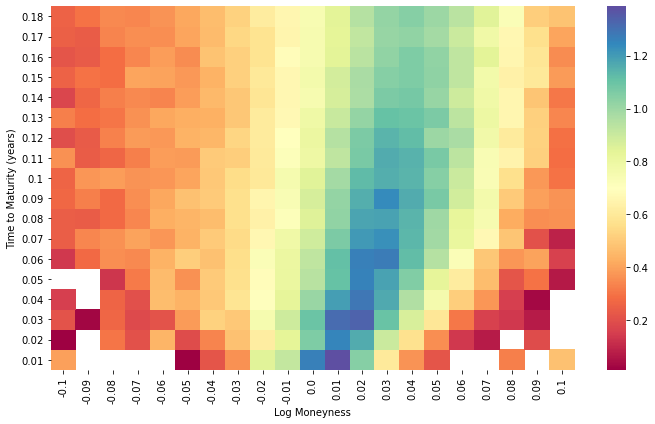

In [38]:
def plot_heatmap(data, values='re'):
    """ Plots the heatmap of the `values` column w.r.t. `Time to Maturity` and `Log Moneyness`.
    """
    data_sort = data.sort_values(values, ascending=True)
    data_pivot = data_sort.pivot(index='Time to Maturity (years)', columns='Log Moneyness', values=values)
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(data_pivot, cmap=plt.cm.Spectral, cbar=True, 
                     xticklabels=data_pivot.columns.values.round(2), 
                     yticklabels=data_pivot.index.values.round(2))
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()
plot_heatmap(df, 're')

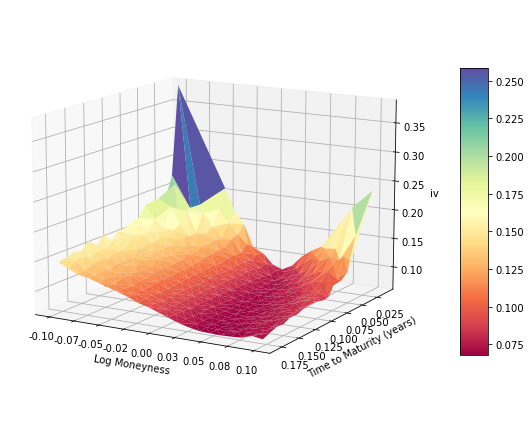

In [39]:
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D

def plot_iv_surface(data, x="Log Moneyness", y='Time to Maturity (years)', z='iv'):
    """ Plots the IV surface
    """
    fig = plt.figure(figsize=(12, 6))
    ax = fig.gca(projection='3d')
    ax.azim = 120
    ax.elev = 13
    
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_zlabel(z)

    ax.invert_xaxis()
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
    
    surf = ax.plot_trisurf(data[x], data[y], data[z], antialiased=True, cmap = plt.cm.Spectral)
    fig.colorbar(surf, shrink=0.7, aspect=10)
    
    plt.tight_layout()
    
    plt.show()
plot_iv_surface(df, z='iv')

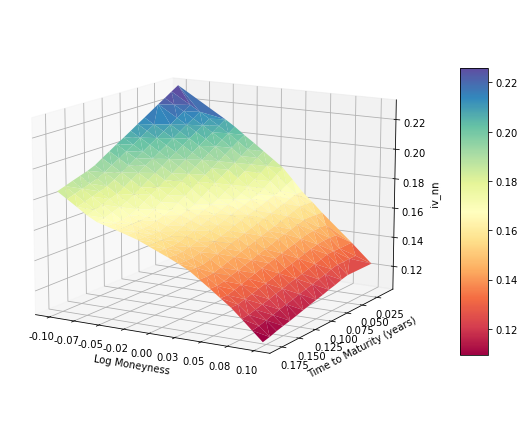

In [40]:
plot_iv_surface(df, z='iv_nn')

In [9]:
from utils import heston_pricer, rBergomi_pricer

In [10]:
from scipy.stats import truncnorm

def model_parameters_initializer(model='heston', random_seed=None):
    """ Initialize model parameters
    """
    if model == 'heston':
        params = [
            10 * np.random.rand(), # lambda
            np.random.rand(), # vbar
            5 * np.random.rand(), # eta
            -1 * np.random.rand(), # rho
            np.random.rand() #v0
        ]
        names = ['lambda', 'vbar', 'eta', 'rho', 'v0']
    elif model == 'rbergomi' or model == 'rBergomi':
        params = [
            truncnorm.rvs(-1.2, 8.6, 0.07, 0.05), # H
            truncnorm.rvs(-3, 3, 2.5, 0.5), # eta
            truncnorm.rvs(-0.25, 2.25, -0.95, 0.2), # rho
            truncnorm.rvs(-2.5, 7, 0.3, 0.1) # v0
        ]
        names = ['H', 'eta', 'rho', 'v0']
    else:
        raise NameError("No such model name: {}".format(model))
    return params, names
params_, names_ = model_parameters_initializer(model='rBergomi', random_seed=None)
params_

[0.03670663104376991,
 2.2000933812328842,
 -0.7147734585646274,
 0.4605784192393519]

In [11]:
def predict_label_jac(sess, model, test_inputs,model_name):
    """ Use a trained model to predict and to return jacobian matrix
    """
    if model_name=='heston':
        model = keras.models.load_model('heston.h5')
    else:
        model = keras.models.load_model('rBergomi.h5')
    print("Loaded Model from disk")
    #compile and evaluate loaded model
    model.compile(optimizer='adam', loss='mean_squared_error')
    pred = model.predict(test_inputs)
    grad_func = tf.gradients(model.output, model.input)
    jac = sess.run(grad_func, feed_dict={model.input: test_inputs})[0]
    return pred, jac

In [12]:
def deep_calibration(tf_sess, nn, K_T, market_quotes, model_name='heston', lambd_init=0.1, beta0=0.25, beta1=0.75, max_iter=1000, tol=1e-8):
    """ Combines LM algorithm with a NN regressor to calibrating model parameters.
    """
    # initialize model parameters
    params, param_names = model_parameters_initializer(model_name)
    
    # initalize learning step
    lambd = lambd_init
    
    n_samples = K_T.shape[0]
    n_params = len(params)
    I = np.eye(n_params)
    Q = market_quotes.reshape((-1, 1)) # shape: [n_samples, 1]
    K_T_values = K_T.values
    
    iter_count = 0
    
    # history to store some useful information during training 
    history = {
        'delta_params': {k: [] for k in param_names},
        'R': [],
        'lambda': [],
        'c_mu': []
    }
    
    # build a input dataframe by combining K_T and model parameters
    for i in range(len(param_names)):
        K_T[param_names[i]] = params[i]
    if model_name=='heston':

        input_data = K_T[['Moneyness','Time to Maturity (years)','lambda','vbar','eta','rho','v0']].values      ##np.insert(K_T_values, [2]*n_params, params, axis=1) # shape: [n_samples, n_params+2]
    else:
        input_data = K_T[['H', 'Moneyness', 'Time to Maturity (years)', 'eta', 'rho', 'v0']].values
    
    iv_nn, J = predict_label_jac(tf_sess, nn, input_data,model_name)
    R = iv_nn - Q # shape: [n_samples, 1]
    J = J[:, 2:] # shape: [n_samples, n_params], excluding K and T
    delta_params = np.linalg.pinv(J.T.dot(J) + lambd * I).dot(J.T.dot(R)).flatten() # vector size: [n_params,]
    
    history['R'].append(np.linalg.norm(R))
    history['lambda'].append(lambd)
    for param_idx, param_name in enumerate(param_names):
        history['delta_params'][param_name].append(delta_params[param_idx])

    while iter_count < max_iter and np.linalg.norm(delta_params) > tol:
        if iter_count % 50 == 0:
            logging.info("{}/{} iteration".format(iter_count+1, max_iter))
        params_new = params - delta_params
        input_data_new = np.insert(K_T_values, [2]*n_params, params_new, axis=1)
        iv_nn_new, J_new = predict_label_jac(tf_sess, nn, input_data_new,model_name)
        R_new = iv_nn_new - Q
        J_new = J_new[:, 2:]
        R_norm = np.linalg.norm(R)
        c_mu = (R_norm - np.linalg.norm(R_new)) / (R_norm - np.linalg.norm(R - J.dot(delta_params)))
        
        history['c_mu'].append(c_mu)
        
        if c_mu <= beta0:
            # reject delta_params
            lambd *= 2 # too slow, use greater lambd
        else:
            params = params_new
            R = R_new
            J = J_new
        if c_mu >=beta1:
            lambd /= 2.0
        
        delta_params = np.linalg.pinv(J.T.dot(J) + lambd * I).dot(J.T.dot(R)).flatten() # vector size: [n_params, ]
        iter_count += 1
        
        history['R'].append(np.linalg.norm(R))
        history['lambda'].append(lambd)
        for param_idx, param_name in enumerate(param_names):
            history['delta_params'][param_name].append(delta_params[param_idx])
    if iter_count < max_iter:
        logging.info("Leave iterations after {} iters".format(iter_count))
        
    return dict(zip(param_names, params)), history

In [45]:
tf.compat.v1.disable_eager_execution()
sess = tf.compat.v1.InteractiveSession()
sess.run(tf.compat.v1.global_variables_initializer())

In [46]:
K_T = X_test.iloc[:500,:][['Moneyness','Time to Maturity (years)']]
K_T_origin = X_test_origin.iloc[:500, :][['Moneyness','Time to Maturity (years)']]

In [47]:
X_test.head()

,H,Moneyness,Time to Maturity (years),eta,rho,v0
0,-0.224647,0.744120,0.327494,0.585675,0.466685,1.733288
1,2.739951,-0.231177,1.203928,-0.781822,-1.523710,-1.433830
2,0.194809,0.852408,0.301868,0.961705,0.328430,-0.642639
3,-0.795508,-0.399744,-0.610912,-0.762449,-0.402033,1.152099
4,0.782763,-0.727378,0.501113,-0.351555,-1.580655,1.428017


In [48]:
K_T_origin.head()

,Moneyness,Time to Maturity (years)
0,1.064951,0.498520
1,0.968319,0.742324
2,1.075680,0.491391
3,0.951618,0.237476
4,0.919156,0.546817


In [49]:


S0 = 1                            
eta = 1.9
rho = -0.9
H = 0.07
v0 = 0.01
market_quotes = np.array([rBergomi_pricer(H, eta, rho, v0, K_T_origin.iloc[i, 1], K_T_origin.iloc[i, 0], S0)[1] for i in range(K_T.shape[0])])
market_quotes = market_quotes.reshape((-1, 1))

In [50]:
valid_idx = ~np.isnan(market_quotes.flatten())
K_T_input = K_T.iloc[valid_idx, :]
market_quotes = market_quotes[valid_idx, :]

In [51]:
import keras as K
import keras
params, history = deep_calibration(sess, model, K_T_input, market_quotes, model_name='rbergomi', lambd_init=0.01, beta0=0.25, beta1=0.75, max_iter=1000)

D:\Anaconda3\envs\tf2_cpu\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\gaolzhu\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
2022-01-28 00:46:22,950 - INFO - 1/1000 iteration


Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk
Loaded Model from disk


2022-01-28 00:46:51,046 - INFO - Leave iterations after 36 iters


In [52]:
mu_hat = pd.DataFrame([params.values()], columns=params.keys())
mu_hat['Moneyness'] = 0
mu_hat['Time to Maturity (years)'] = 0
SCALER.inverse_transform(mu_hat[['H', 'Moneyness', 'Time to Maturity (years)', 'eta', 'rho', 'v0']])


,H,Moneyness,Time to Maturity (years),eta,rho,v0
0,0.087744,0.991224,0.407418,3.872348,-0.902369,0.1224


## 根据得到的参数生成路径，带入GRU模型

In [1]:
from utils import heston_pricer
import numpy as np
import QuantLib as ql
from py_vollib.black_scholes.implied_volatility import implied_volatility
from py_lets_be_rational.exceptions import BelowIntrinsicException
import logging

from rbergomi.rbergomi import rBergomi
def rBergomi_pricer(H, eta, rho, v0, tau, K, S0, MC_samples=40000):
    """Computes European Call price under rBergomi dynamics with MC sampling.
    
    Parameters:
    -----------
        H: Hurst parameter
        eta: volatility of variance
        rho: correlation between stock and vol
        v0: spot variance
        tau: time to maturity in years (365 trading days per year)
        K: strike price
    """
    rB = rBergomi(n=365, N=MC_samples, T=tau, a=H-0.5,S0=S0)
    dW1, dW2 = rB.dW1(), rB.dW2()
    Y = rB.Y(dW1)
    dB = rB.dB(dW1, dW2, rho)
    xi = v0
    V = rB.V(Y, xi, eta)
    S = rB.S(V, dB)
    ST = S[:, -1]
    price = np.mean(np.maximum(ST-K, 0))
    # print("price is ", price,aa.shape)

    # price 是期权价格，
    # S 是股票价格，将这部分数据传出来带入后面的GRU模型中去

    # 更改rbergomi模型，将模型中的S0当作一个初始话的参数，根据不同的
    
    # check numerical stability
    if price <= 0 or price + K < S0:
        iv = np.nan
        logging.debug("NumStabProblem: Price {}. Intrinsic {}. Time {}. Strike {}.".format(price, S0-K, tau, K))
    else:
        logging.debug("Success: Price {} > intrinsic {}".format(price, S0-K))
        iv = implied_volatility(price, S0, K, tau, 0, 'c')
    return S,iv # price, iv

H = 0.087744	
eta = 1.872348
rho = -0.902369
v0 = 0.1224
tau = 30/365
K = 100
S0 = 100
# rBergomi_pricer(H, eta, rho, v0, tau, K, S0, MC_samples=120000)
a,b = rBergomi_pricer(H, eta, rho, v0, tau, K, S0, MC_samples=120000)


In [2]:
np.save('./data/deep_hedging/rb_price',a)

## 检验股票价格数据和生成过程中的dW2的数据

In [3]:
import matplotlib.pyplot as plt

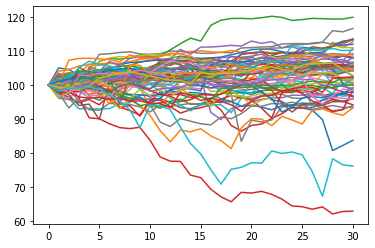

In [4]:
for i in range(70):
    plt.plot(a[10*i+1,:])
plt.show()

In [5]:
## 查看随机变量的结果
MC_samples = 4000
rB = rBergomi(n=365, N=MC_samples, T=tau, a=H-0.5,S0=S0)
dW1, dW2 = rB.dW1(), rB.dW2()

In [6]:
dW2.shape

(4000, 30)

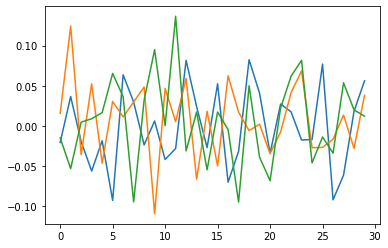

In [7]:
for i in range(3):
    plt.plot(dW2[10*i+1,:])

plt.show()